In [85]:
import pandas
import seaborn
import sklearn
import functions as covid_lib
from random import random
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt

import dash
import dash_core_components as dcc
import dash_html_components as html
import plotly.graph_objects as go
from dash.dependencies import Input, Output 

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

---
## 1st Dataset : John Hopkins Data

In [86]:
## John Hopkins Center for Systems Science and Engineer Data Base URL
## Contains timeseries data
## This set of data is updated daily
baseURL = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/"

cumulated_confirmed_url = baseURL + "time_series_covid19_confirmed_global.csv"
cumulated_deaths_url    = baseURL + "time_series_covid19_deaths_global.csv"
cumulated_recovered_url = baseURL + "time_series_covid19_recovered_global.csv"

cumulated_confirmed     = pd.read_csv(cumulated_confirmed_url)
cumulated_deaths        = pd.read_csv(cumulated_deaths_url)
cumulated_recovered     = pd.read_csv(cumulated_recovered_url)

## Processed Dataset
## Combine by Country/Region
cumulated_confirmed_country = covid_lib.df_groupby_countries(cumulated_confirmed)
cumulated_deaths_country = covid_lib.df_groupby_countries(cumulated_deaths)
cumulated_recovered_country = covid_lib.df_groupby_countries(cumulated_recovered)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [87]:
# US_confirmed.to_csv('cululated_confirmed.csv', index = False)

In [88]:
print("Confirmed data shape : " + str(cumulated_confirmed_country.shape))
print("Recovered data shape : " + str(cumulated_deaths_country.shape))
print("Deaths data shape : " + str(cumulated_recovered_country.shape))

Confirmed data shape : (188, 171)
Recovered data shape : (188, 171)
Deaths data shape : (188, 171)


In [89]:
# ## To find specific instances on certain countries
# ## Consider grouping by countries to simplify the analysis process
# cumulated_confirmed.loc[cumulated_confirmed["Country/Region"]=="US"].head()

In [90]:
cumulated_confirmed_country.head()

,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,...,6/28/20,6/29/20,6/30/20,7/1/20,7/2/20,7/3/20,7/4/20,7/5/20,7/6/20,7/7/20
0,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,...,30967,31238,31517,31836,32022,32324,32672,32951,33190,33384
1,Albania,41.1533,20.1683,0,0,0,0,0,0,0,...,2402,2466,2535,2580,2662,2752,2819,2893,2964,3038
2,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,...,13273,13571,13907,14272,14657,15070,15500,15941,16404,16879
3,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,...,855,855,855,855,855,855,855,855,855,855
4,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,...,267,276,284,291,315,328,346,346,346,386


In [91]:
unique_countries = cumulated_confirmed_country["Country/Region"].unique()

In [92]:
cumulated_deaths_country[cumulated_deaths_country["Country/Region"]=="Taiwan*"]


,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,...,6/28/20,6/29/20,6/30/20,7/1/20,7/2/20,7/3/20,7/4/20,7/5/20,7/6/20,7/7/20
165,Taiwan*,23.7,121.0,0,0,0,0,0,0,0,...,7,7,7,7,7,7,7,7,7,7


In [93]:
## Call this only if you wanna wait forever
proceed = False
if proceed:
    for country in unique_countries:
        covid_lib.plt_all_cases_increase_cases(country, cumulated_confirmed_country  )

In [94]:
# US_confirmed = cumulated_confirmed.loc[cumulated_confirmed["Country/Region"]=="US"].head()
# US_confirmed

# all_cases, increased_case = covid_lib.df_to_timeseries(US_confirmed, 7)

In [95]:
query_country = "Taiwan*"
query_confirmed = cumulated_confirmed.loc[cumulated_confirmed["Country/Region"]==query_country]
queried_total_cases, queried_increased_case = covid_lib.df_to_timeseries(query_confirmed, 1)
model = SARIMAX(queried_total_cases, order=(1, 1, 1), seasonal_order=(1, 1, 1, 1))
model_fit = model.fit(disp=False)
yhat = model_fit.predict(len(queried_total_cases), len(queried_total_cases)+10)
print(yhat)
covid_lib.plot_all( queried_total_cases, queried_increased_case, yhat , query_country )

[449.00612037 449.00903304 449.01305315 449.01674292 449.02052408
 449.02428109 449.02804428 449.03180593 449.03556796 449.03932989
 449.04309185]


### Taiwan Analysis

In [96]:
# TW_confirmed = cumulated_confirmed.loc[cumulated_confirmed["Country/Region"]=="Taiwan*"].head()
# total_cases, increased_case = covid_lib.df_to_timeseries(TW_confirmed, 7)


### US Analysis

In [97]:
US_confirmed = cumulated_confirmed.loc[cumulated_confirmed["Country/Region"]=="US"].head()
total_cases, increased_case = covid_lib.df_to_timeseries(US_confirmed, 7)


<IPython.core.display.Javascript object>

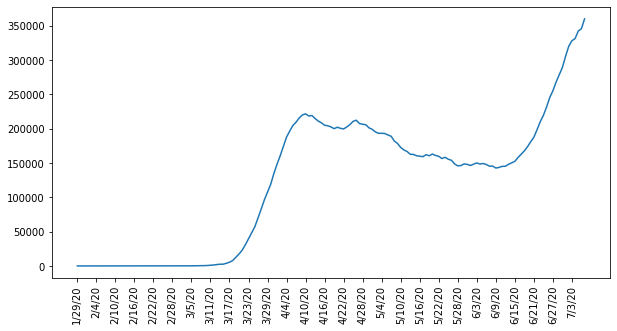

In [98]:
figure = plt.figure(figsize = (10,5))
plt.plot(increased_case)
plt.xticks(np.arange(0, len(increased_case.dropna()), 6)) 
plt.xticks(rotation=90)
plt.savefig("Infected Case.jpg",  bbox_inches='tight')

In [99]:
covid_lib.plot_all( total_cases, increased_case, yhat , "US" )

---

### Total Model Building

/home/mavericku/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.

/home/mavericku/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



Test RMSE: 20.952


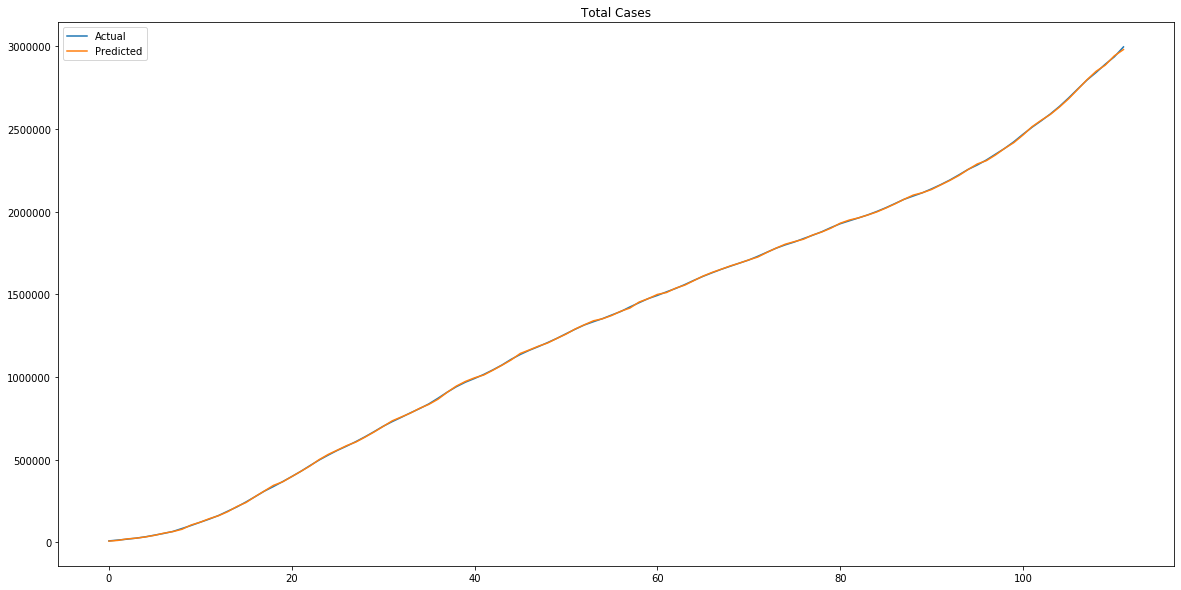

In [100]:
predictions_total, model_total = covid_lib.SARIMA_PREDICT(total_cases,"Total Cases", order_tuple = (0,1,0), fit_param = (True, True))

#### Predict future total Cases

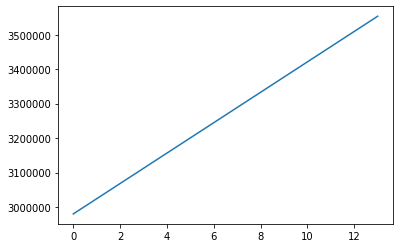

In [101]:
# today and tomorrow
temp = model_total.forecast(14)
plt.plot(temp)

---

#### Increase Model Building

/home/mavericku/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



Test RMSE: 17.826


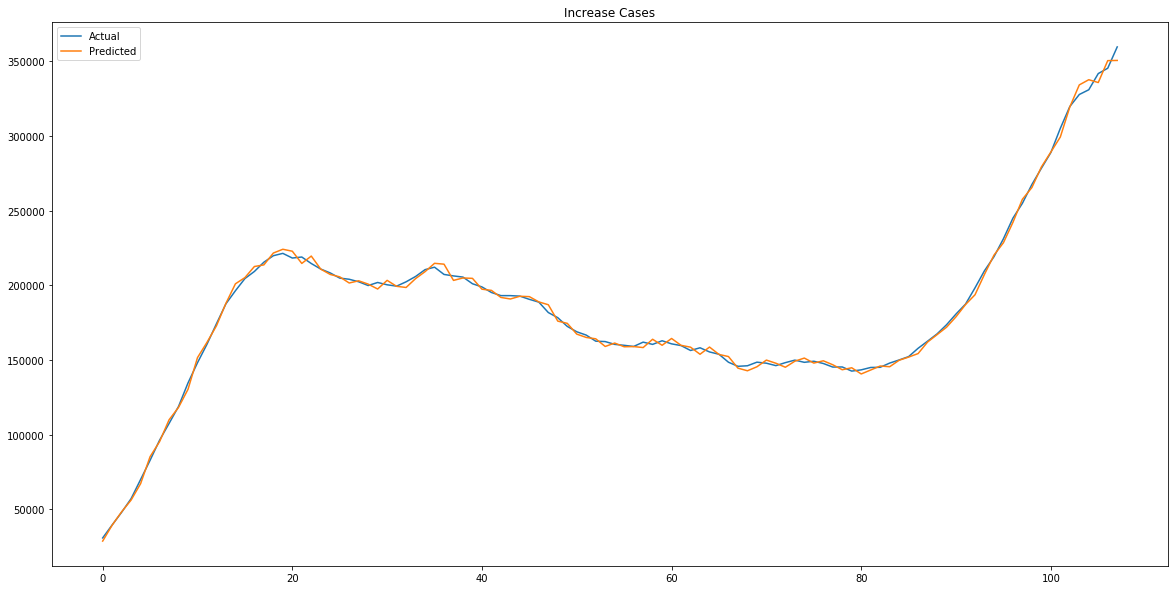

In [102]:
increase_temp = increased_case.values 
predictions_increase, model_increase = covid_lib.SARIMA_PREDICT(increase_temp, "Increase Cases",  is_increase_case = True, fit_param = (True,True) )

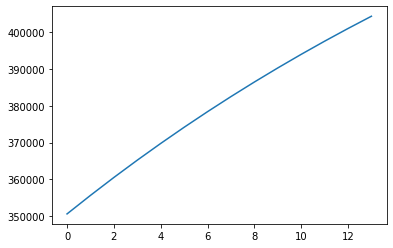

In [103]:
# today and tomorrow
temp = model_increase.forecast(14)
plt.plot(temp)

---

In [104]:
# total_cases

In [105]:
from numpy import array
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [108]:
temp = total_cases.transpose()
# temp

In [ ]:
temp1, temp2 = split_sequence(total_cases.transpose(), 3)

In [ ]:
temp1

In [ ]:
temp2